<a href="https://colab.research.google.com/github/Subisha002/fake-news-classification/blob/main/fake_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TOPIC -  FAKE NEWS CLASSIFICATION USING FINE TURNING TRANSFORMERS**


INSTALLING DATASET FROM KAGGLE


In [1]:
!pip install opendatasets


In [2]:
import opendatasets as os

os.download("https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: subisha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification


100%|██████████| 39.0M/39.0M [00:00<00:00, 46.9MB/s]


INSTALLING REQURIED LIBRARIES


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=95c1cb919a1adf351198b0ed81e696763253c36dd271e9b7812e2d5971dbc6c9
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!pip install tensorflow

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from wordcloud import WordCloud
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

DATA PREPROCESSING


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('stopwords')

def clean_html(text):
    """Removes HTML tags from text."""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def punct(text):
    """Removes punctuation from text."""
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_digits(text):
    """Removes digits from text."""
    text = re.sub(r'\d+', '', text)
    return text

def remove_links(text):
    """Removes links from text."""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    return text

def remove_special_characters(text):
    """Removes special characters from text."""
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_(text):
    """Removes underscores from text."""
    text = re.sub(r'_', '', text)
    return text

def removeStopWords(text):
    """Removes stop words from text."""
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word.lower() not in stop_words])
    return text

def lower(text):
    """Converts text to lowercase."""
    return text.lower()

def email_address(text):
    """Removes email addresses from text."""
    text = re.sub(r'\S+@\S+', '', text)
    return text

def non_ascii(text):
    """Removes non-ASCII characters from text."""
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


LOADING THE TRAIN,TEST and EVALUATION DATASETS

In [7]:
import pandas as pd
train_df = pd.read_csv("/content/fake-news-classification/train (2).csv",delimiter=';')
train_df.drop('Unnamed: 0',axis=1,inplace=True)
train_df.head()

,title,text,label
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [8]:
train_df.shape

(24353, 3)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24353 non-null  object
 1   text    24353 non-null  object
 2   label   24353 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 570.9+ KB


In [10]:
train_df.describe()

,label
count,24353.000000
mean,0.543917
std,0.498078
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
train_df.isna().sum()

,0
title,0
text,0
label,0


In [12]:
train_df.duplicated().sum()

1

In [13]:
train_df = train_df.drop_duplicates()
train_df.shape

(24352, 3)

In [14]:
test_df = pd.read_csv('/content/fake-news-classification/test (1).csv',delimiter=';')
test_df.drop('Unnamed: 0',axis=1,inplace=True)
test_df.head()

,title,text,label
0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1
1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1
2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1
4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1


In [15]:
test_df.shape

(8117, 3)

In [16]:

test_df.isnull().sum()

,0
title,0
text,0
label,0


In [17]:
test_df.duplicated().sum()

0

In [18]:

evaluation_df = pd.read_csv("/content/fake-news-classification/evaluation.csv",delimiter=';')
evaluation_df.drop('Unnamed: 0',axis=1,inplace=True)
evaluation_df.head()

,title,text,label
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [19]:
evaluation_df.shape

(8117, 3)

In [20]:
evaluation_df.isna().sum()

,0
title,0
text,0
label,0


In [21]:
evaluation_df.duplicated().sum()

0

DATA EXPLORATION


In [22]:
train_df['num_words'] = train_df.text.apply(len)
train_df.num_words.describe()

,num_words
count,24352.000000
mean,2501.363789
std,2114.069417
min,1.000000
25%,1301.000000
50%,2224.000000
75%,3130.250000
max,48835.000000


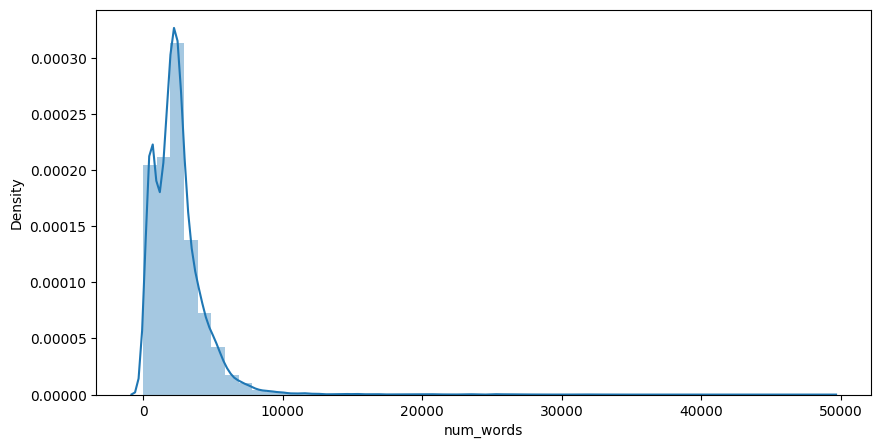

In [23]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(train_df['num_words']);

In [24]:
max_len = 120

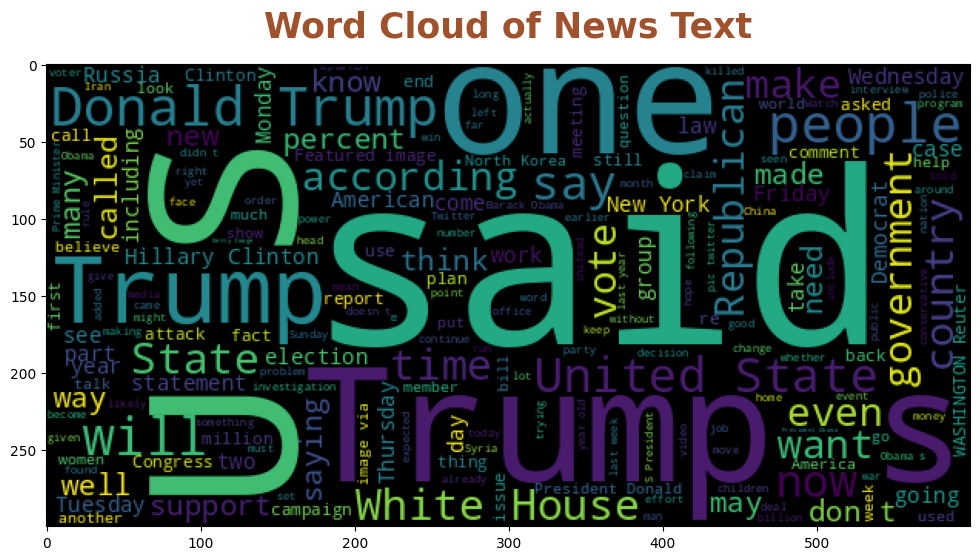

In [25]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(train_df.text))
plt.imshow(wc)
plt.title('Word Cloud of News Text',fontsize=25,pad=20,fontweight='bold',color='sienna')
plt.show();

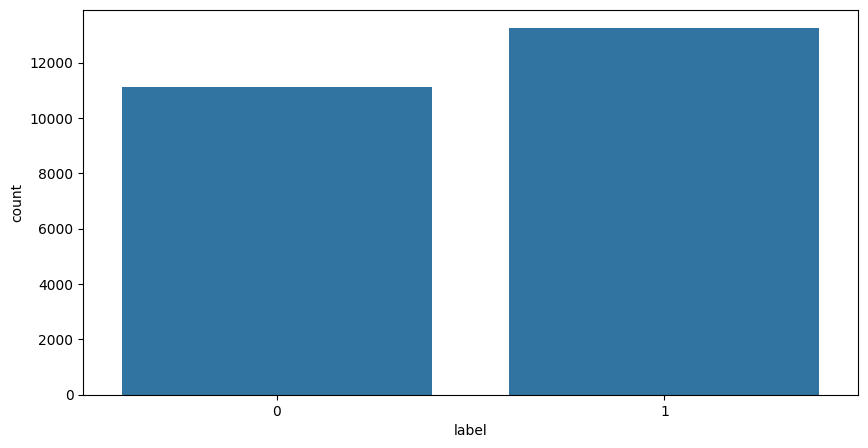

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=train_df);

In [27]:
#TEXT PREPROCESSING

def preprocess_text(data,col):
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    return data


In [28]:
preprocessed_train = preprocess_text(train_df,'text')
preprocessed_test = preprocess_text(test_df,'text')
preprocessed_eval = preprocess_text(evaluation_df,'text')

DOWNLOADING PRETRAINED TOKENZIER AND BERT

In [29]:
model_name = 'mrm8488/bert-tiny-finetuned-fake-news-detection'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = TFAutoModelForSequenceClassification.from_pretrained(model_name,from_pt=True)

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


PERFORMING TEXT TOKENIZATION

In [30]:
X_train = tokenizer(text=preprocessed_train.text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   return_tensors='tf',
                   verbose=1)

X_test = tokenizer(text=preprocessed_test.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)

X_eval = tokenizer(text=preprocessed_eval.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)

ENCODING TARGET LABEL CLASSES

In [31]:
scaler = LabelEncoder()
train_df.label = scaler.fit_transform(train_df.label)
test_df.label = scaler.transform(test_df.label)
evaluation_df.label = scaler.transform(evaluation_df.label)

MODEL TRAINING AND EVALUTION

In [32]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [33]:
# Wrap the bert call in a custom layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):  # Add **kwargs to the constructor
        super(BertLayer, self).__init__(**kwargs) # Pass **kwargs to the superclass constructor
        self.bert_model = bert_model

    def get_config(self):
        config = super(BertLayer, self).get_config() # Call super().get_config() with class and instance
        config.update({
            'bert_model': self.bert_model
        })
        return config

    def call(self, inputs):
        input_ids, attention_mask = inputs
        embeddings = self.bert_model(input_ids, attention_mask=attention_mask)[0]
        return embeddings

In [34]:
# Create an instance of the custom layer
bert_layer = BertLayer(bert)

# Use the custom layer in your model
embeddings = bert_layer([input_ids, attention_mask])
output = Flatten()(embeddings)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.15)(output)
output = Dense(units=1,activation='sigmoid')(output)
model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 120)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 120)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 2)              │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2)              │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │          1,536 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 169,473 (662.00 KB)

 Trainable params: 167,681 (655.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

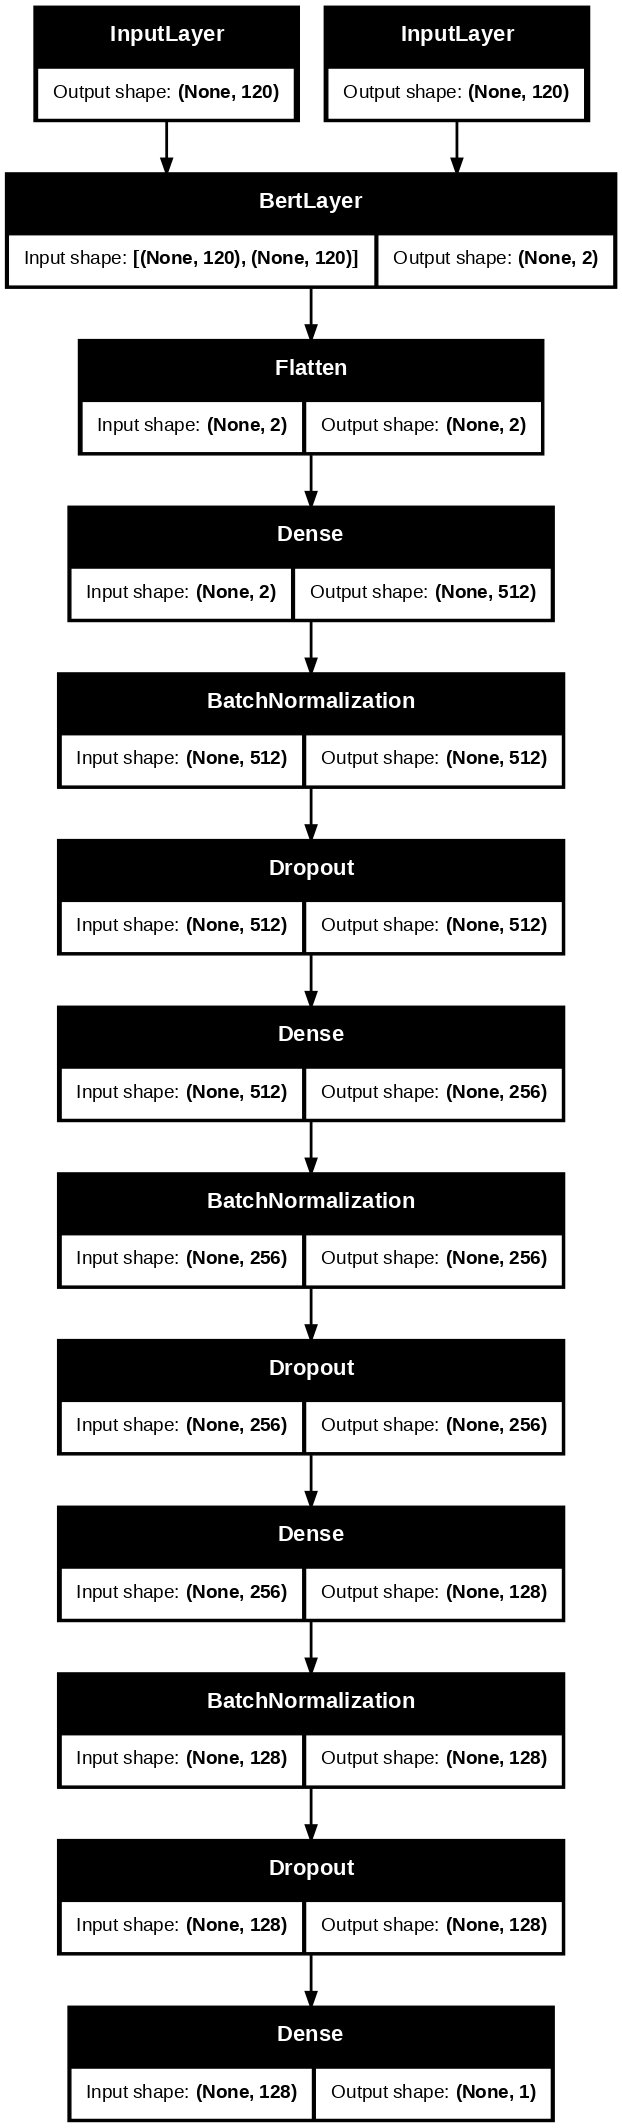

In [35]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100)

In [36]:
optimizer = Adam(learning_rate=4e-5,epsilon=1e-7,decay=1e-2,clipnorm=1.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [37]:
def step_decay(epoch, lr):
    drop_rate = 0.5
    step_size = 10
    return lr * drop_rate ** (epoch // step_size)

In [38]:
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=10,restore_best_weights=True,verbose=1)
lrs = LearningRateScheduler(step_decay,verbose=1)
mc = ModelCheckpoint(filepath='fake_news_classifier.keras',monitor='val_accuracy',save_best_only=True,mode='max',save_freq='epoch',verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.label,
             epochs=10,
             batch_size=256,
             callbacks=[es,lrs,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
             )


Epoch 1: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7911 - loss: 0.4432
Epoch 1: val_accuracy improved from -inf to 0.97339, saving model to fake_news_classifier.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.7923 - loss: 0.4412 - val_accuracy: 0.9734 - val_loss: 0.4159 - learning_rate: 4.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 2/10
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9695 - loss: 0.1361
Epoch 2: val_accuracy improved from 0.97339 to 0.97437, saving model to fake_news_classifier.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9695 - loss: 0.1361 - val_accuracy: 0.9744 - val_loss: 0.2564 - learning_rate: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 3/10
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9693 - loss: 0.1321
Epoch 3: val_accur

CLASSIFICATION REPORT


254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9726 - loss: 0.1181
Evaluation Loss: 0.11784549057483673
Evaluation Accuracy: 0.9721571803092957
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3803
           1       0.99      0.96      0.97      4314

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



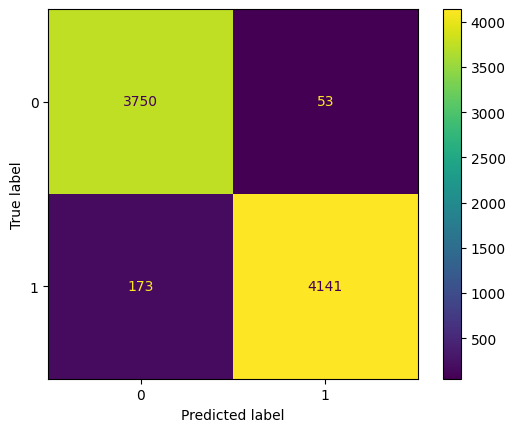

In [39]:
import matplotlib.pyplot as plt
# Evaluate the model on the evaluation dataset
evaluation_results = model.evaluate(
    x={'input_ids': X_eval['input_ids'], 'attention_mask': X_eval['attention_mask']},
    y=evaluation_df.label
)

print("Evaluation Loss:", evaluation_results[0])
print("Evaluation Accuracy:", evaluation_results[1])

# Make predictions on the evaluation dataset
y_pred = model.predict({'input_ids': X_eval['input_ids'], 'attention_mask': X_eval['attention_mask']})
y_pred_classes = (y_pred > 0.5).astype(int) # Convert probabilities to class labels

# Generate classification report and confusion matrix
print(classification_report(evaluation_df.label, y_pred_classes))

cm = confusion_matrix(evaluation_df.label, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scaler.classes_)
disp.plot()
plt.show()

# Optionally, you can save the model or further analyze the results


FAKE NEWS PREDICTION

In [40]:
import pandas as pd
# Assuming 'model' and other necessary variables are defined from the previous code

def predict_fake_news(text):
    """Predicts if the given text is fake or real news."""
    # Preprocess the input text
    preprocessed_text = preprocess_text(pd.DataFrame({'text': [text]}), 'text')

    # Tokenize the preprocessed text
    inputs = tokenizer(
        text=preprocessed_text['text'].tolist(),
        max_length=max_len,
        padding=True,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='tf'
    )

    # Make prediction
    prediction = model.predict({'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']})
    predicted_class = (prediction > 0.5).astype(int)[0][0]

    # Map the predicted class to labels (0 for real, 1 for fake in this example)
    return "Fake News" if predicted_class == 1 else "Real News"

# To check Fake News and Real News

text_to_check ="SACRAMENTO, Calif. (Reuters) - California Gove...	"
predicted_label = predict_fake_news(text_to_check)
print(f"The news is predicted to be: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The news is predicted to be: Fake News


TO SAVE THE MODEL


In [41]:
# Save the Keras model using the standard save method
model.save("fake_news_model.keras")



In [42]:
# Save the tokenizer using save_pretrained
tokenizer.save_pretrained("fake_news_model")

('fake_news_model/tokenizer_config.json',
 'fake_news_model/special_tokens_map.json',
 'fake_news_model/vocab.txt',
 'fake_news_model/added_tokens.json',
 'fake_news_model/tokenizer.json')

In [46]:
!git config --global user.name "subisha002"
!git config --global user.email "subisha002@gmail.com"
